In [ ]:
#supposed the input is in df, the data of X_test=['อย่า ลืม ติดตาม ชม รายการ พิเศษ','ด่วน ลด แบบ จัดเต็ม ของแถม มากมาย']
#keras embed method, will update with the tokenizer and weight file
#python3.9 keras3.01

In [19]:
import re
import pandas as pd
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import Model #new 3 
from sklearn.svm import SVC #new 3 
import joblib #new 3


In [29]:
def load_model(file,weight_file): #new
    with open(file, "r") as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights(weight_file) 
    return model

def preproces_df1(df): #new 2
    df_a = df
    df_a['split_text'] = df_a.apply(lambda row: word_tokenize(row['tweet_text'],engine="newmm",keep_whitespace=False), axis=1) #use this
    df_a['combined'] = [' '.join(lst) for lst in df_a['split_text']]
    df_a['cleaned'] = df_a['combined'].apply(deEmojify)
    df_a['cleaned'] = df_a['cleaned'].apply(stopwords_rm) 
    df_a['cleaned'] = alone(df_a) #new
    df_a['split_cleaned'] = df_a.apply(lambda row: word_tokenize(row['cleaned'],engine="newmm",keep_whitespace=False), axis=1)
    #df_a['word_length'] = df_a['split_cleaned'].str.len()
    df_a = df_a.dropna(subset=['tweet_text']) #new

    return df_a

def preproces_df(csv):
    #preprocessing the data from df 
    df_a = pd.read_csv(csv)
    df_a = preproces_df1(df_a) #new 2

    df_a['contain_area'],df_a['contain_good'] = '2','2' #new -holder new column
    for i in range(df_a['split_cleaned'].shape[0]):  #new
        if 'ดี' in df_a['split_cleaned'].iloc[i]: 
            df_a['contain_good'].iloc[i] = '1'
        else:
            df_a['contain_good'].iloc[i] = '0'

    for i in range(df_a['split_cleaned'].shape[0]): #new
        if 'พื้นที่' in df_a['split_cleaned'].iloc[i]:
            df_a['contain_area'].iloc[i] = '1'
        else:
            df_a['contain_area'].iloc[i] = '0'

    return df_a

#loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#sub function below---------------------------------------------------------------------------------------------------
def stopwords_rm(text):
    stopwords = set(thai_stopwords())
    stopwords.update(["nan", "-", "_", "", " ", "฿" ,"ค่ะ", "ครับ", "จ้า"])  # Add more stopwords as needed

    # Remove stopwords from the text
    cleaned_text = ' '.join(word for word in text.split() if word not in stopwords)
    return cleaned_text

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def alone(df):
    print('Are you alone?')
    i = 0 #row number
    df['cleaned1'] = ''
    for row in df['cleaned']:
        words = row.split() #j is array of string
        cleaned = [word for word in words if len(word) > 1]
        cleaned_string = " ".join(cleaned)
        df['cleaned1'].iloc[i] = cleaned_string
        i += 1
    print('done cleaning alone')
    return df['cleaned1']

def pau_anal(df_a): #new - do all the df
    contain_good = df_a['contain_good'].to_numpy()
    good_reshaped = np.reshape(contain_good, (contain_good.shape[0], 1))
    good_reshaped = [int(x) for n in range(int(df_a.shape[0]))for x in good_reshaped[n][0]] #list in int 
    np_good = np.array(good_reshaped)
    good_reshaped = np.reshape(np_good, (np_good.shape[0], 1))

    contain_area = (df_a['contain_area']).to_numpy()
    area_reshaped = np.reshape(contain_area, (contain_area.shape[0], 1))
    area_reshaped = [int(x) for n in range(int(df_a.shape[0]))for x in area_reshaped[n][0]] #list in int 
    np_area = np.array(area_reshaped)
    area_reshaped = np.reshape(np_good, (np_good.shape[0], 1))
    return good_reshaped, area_reshaped


# Load model and weight
def Main(df):
    model = load_model("./org_model_architecture.json", "./org_model_weights.h5") #new
    df_1 = preproces_df1(df) #new 2
    df = df_1 #new 2 
    print('predicting...')
    MAX_SEQUENCE_LENGTH = 63 #training file 44
    MAX_WORDS = 2500 #2000

    tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
    tokenizer.fit_on_texts(df.cleaned.values)
    #X_test=[df['cleaned']] #new 2 
    X_test=tokenizer.texts_to_sequences(df.cleaned.values) #new 2 
    print('shit1', len(X_test))
    X_test=pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(X_test)
    org = ['public work (โยธา)', 'municipal office (เทศกิจ)' ,'police department']
    pred_org = np.round(predictions)#new2
    pred_org = pred_org.astype(int) #new2

    
    print('result int: ', pred_org) #new2
    org_result = [org[i[0]] for i in pred_org] #new2
    print('classs predicted: ', org_result) #new2
    print('confidence %:', predictions) #new2
    #for checking from ori excel
    #print('real cat is : ',df['org'].iloc[-1])
    if 'org' not in df.index:
        df['org'] = ''   #make column in df

    df['org'] = org_result
    return df


def Main_relevant(df):
    model = load_model("./model/relevant_arch.json", "./model/relevant_weight_hyper.h5")#new this one old->./relevant_model_architecture.json
    df_1 = preproces_df(df) #new 2 df['tweet_text'] เป็นstring ของ tweet 
    df = df_1 #new 2
    print('predicting...')

    MAX_SEQUENCE_LENGTH = 132 #new
    MAX_WORDS = 3500 #new

    tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
    tokenizer.fit_on_texts(df.cleaned.values)
    word_index = tokenizer.word_index #new

    X = tokenizer.texts_to_sequences(df.cleaned.values) #new2
    print('X 2 ', X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #new
    print('X 3 ', X)
    good_reshaped, area_reshaped = pau_anal(df) #new - adding pau good, area
    
    # Use np.hstack to append new column to the right

    X = np.hstack((X, good_reshaped)) #new
    X = np.hstack((X, area_reshaped)) #new
    X_test = X #new
    #X_test=[df['cleaned'].iloc[-1]] #new- delete
    #X_test=tokenizer.texts_to_sequences(X_test) #new- delete
    #X_test=pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH) #new- delete
    #predictions = model.predict(X_test) #new 3 
    feature_extraction_model = Model(inputs=model.input, outputs=model.layers[-3].output) #new 3
    features = feature_extraction_model.predict(X_test) #new 3
  
    loaded_model = joblib.load('./model/svc_model.pkl') #new 3
    print(features.shape, 'feature shape ')
    predictions = loaded_model.predict(features)    #new 3

    print(type(predictions))
    rev = ['not relevant','relevant']

    print('result:', predictions)
    print('shape', predictions.shape)
    print('shape', type(predictions))
    pred_int = np.round(predictions) #new2
    pred_int  = pred_int.astype(int) #new2
    print('ar', pred_int)

    class_pred = [rev[i[0]] for i in pred_int]
    print('classs predicted: ', class_pred)
    print('confidence %: ', predictions)
    #for checking
    #print('real cat is : ',df['rev'])
    print('big prediction', predictions.shape)
    print('big dick', df.shape)

    if 'relevant_pred' not in df.index: #new 2
        df['relevant_pred'] = ''  #make column in df

    df['relevant_pred'] = class_pred #new 2

    df_new = df[df['relevant_pred'] != 'not relevant'] #new 2 drop
    return df_new, df


In [23]:
df_1 = pd.read_csv("./Jetson_df_y4s2_final.csv")

In [13]:
df_1['relevant'].value_counts()

relevant
False    280
True     271
Name: count, dtype: int64

In [30]:
df_updated, df_drop = Main_relevant("./Jetson_df_y4s2_final.csv") #input the df location

#df_y4s2_final_new.csv

Are you alone?
done cleaning alone


C:\Users\natkn\AppData\Local\Temp\ipykernel_23140\2266882300.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned1'].iloc[i] = cleaned_string
C:\Users\natkn\AppData\Local\Temp\ipykernel_23140\2266882300.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned1'].iloc[i] = cleaned_string
C:\Users\natkn\AppData\Local\Temp\ipykernel_23140\2266882300.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned1'].il

predicting...
X 2  [[1032, 1590, 1, 765, 349, 113, 1591, 75, 1592, 1593, 1033, 1034, 766, 1594, 42, 16, 212, 35, 350, 306, 1595, 1596, 3, 99, 149, 404, 767, 1597, 1033, 1034, 766, 1598, 213, 1599, 1600, 1601], [1602, 1603, 1035, 608, 235, 1604, 1036, 29, 1605, 1037, 1035, 1606, 1036, 1607, 1608, 1609, 768, 135, 405, 1610, 1037, 1611, 236, 1612, 609, 1613, 1614, 1615, 1616, 270, 307, 150, 499, 271], [1038, 164, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 406, 610, 39, 1624, 1625, 1626, 1627, 1039, 39, 350, 1628, 769, 500, 501, 502, 1038, 611, 33, 407, 4, 1629, 1630, 1631, 1040, 1632, 123, 1633, 408, 1634, 1635, 1636, 1637, 1638, 1639], [237, 26, 136, 503, 409, 1640, 351, 1641, 150, 1642, 1041, 1042, 1643, 503, 504, 3, 308, 1043, 1644, 1645, 1646, 410, 1647, 272, 352, 770, 1648, 182, 771, 1649, 410, 273, 1650, 100, 1651, 1652, 101, 772, 137, 270, 25, 274, 183, 214, 1653], [6, 70, 1, 1654, 1044, 612, 773, 505, 275, 4, 1655, 184, 774, 1656, 309, 1657, 1658, 1045, 1046, 1047, 1659, 114, 1660,

ValueError: X has 256 features, but SVC is expecting 64 features as input.

In [ ]:
import time
df_drop
np.random.seed(int(time.time()))
false_rows = df_a[df_a['relevant'] == False]
rows_to_keep = false_rows.sample(n=312, random_state=42) 

df_dropped = df_a[df_a['relevant'] != False]
df_a = pd.concat([df_dropped,rows_to_keep])
df_a['relevant'].value_counts() 

In [15]:
df_drop['relevant'].value_counts() 

relevant
False    280
True     271
Name: count, dtype: int64

In [16]:
df_drop['relevant_pred'].value_counts() 

relevant_pred
not relevant    293
relevant        258
Name: count, dtype: int64

In [68]:
df_1['relevant'].value_counts() 

relevant
False    3327
True      271
Name: count, dtype: int64

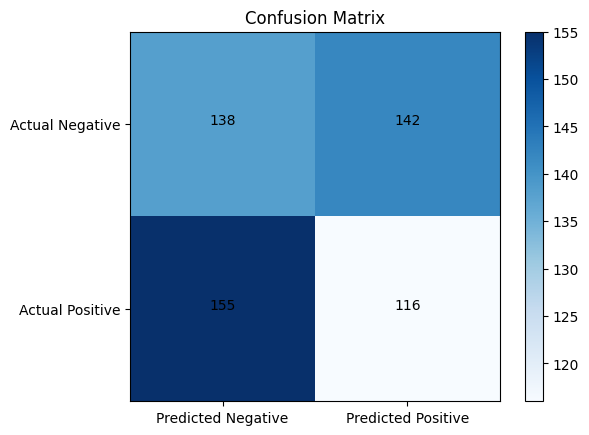

In [17]:
import matplotlib.pyplot as plt
import numpy as np
df = df_drop
True_pos = df[(df['relevant'] == True) & (df['relevant_pred'] == 'relevant')].shape[0]
True_neg = df[(df['relevant'] == False) & (df['relevant_pred'] == 'not relevant')].shape[0]
False_pos = df[(df['relevant'] == False) & (df['relevant_pred'] == 'relevant')].shape[0]
False_neg = df[(df['relevant'] == True) & (df['relevant_pred'] == 'not relevant')].shape[0]

confusion_matrix = np.array([[True_neg, False_pos],
                              [False_neg, True_pos]])

# Plot the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set the axis labels
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])

# Display the values in the matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment='center', color='black')

plt.show()



In [42]:
df = Main(df_updated)

C:\Users\natkn\AppData\Local\Temp\ipykernel_11056\1921872745.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['split_text'] = df_a.apply(lambda row: word_tokenize(row['tweet_text'],engine="newmm",keep_whitespace=False), axis=1) #use this
C:\Users\natkn\AppData\Local\Temp\ipykernel_11056\1921872745.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['combined'] = [' '.join(lst) for lst in df_a['split_text']]
C:\Users\natkn\AppData\Local\Temp\ipykernel_11056\1921872745.py:12: SettingWithCopyWar

Are you alone?
done cleaning alone
predicting...
shit1 280
shit 280
6/9 [===================>..........] - ETA: 0s

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/embedding_1/embedding_lookup' defined at (most recent call last):
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\natkn\AppData\Local\Temp\ipykernel_11056\3102576467.py", line 1, in <module>
      df = Main(df_updated)
    File "C:\Users\natkn\AppData\Local\Temp\ipykernel_11056\1921872745.py", line 119, in Main
      predictions = model.predict(X_test)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_1/embedding_1/embedding_lookup'
indices[22,44] = 2014 is not in [0, 2000)
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]] [Op:__inference_predict_function_43881]

In [ ]:
'''if df_drop[-1] == df_updated[-1]: #relevant
    df = Main(df_updated)
    print('relevant, updated')
    print('org is : ', )
else: 
    print('irrelevant, row deleted')
    print('deleted row : ', df_drop)''' 

In [34]:
df_drop.columns

Index(['index', 'username', 'tweet_id', 'tweet_text', 'org', 'relevant',
       'category', 'query', 'datetime_of_tweet', 'datetime_of_query', 'link',
       'mentioned_location', 'location', 'image', 'split_text', 'combined',
       'cleaned', 'cleaned1', 'split_cleaned', 'contain_area', 'contain_good'],
      dtype='object')

In [36]:
df_drop['org']

0      department of public work
1              police department
2      department of public work
3      department of public work
4               municipal office
                 ...            
548             municipal office
549                          NaN
550                          NaN
551                          NaN
552                          NaN
Name: org, Length: 553, dtype: object

In [ ]:
df_drop['relevant']

In [48]:
df.iloc[-1]

index                                                              1004
username                                                    AitKanphong
tweet_id                                            1701505503111819503
tweet_text            เหล่าสิงห์มอเตอร์ไซด์สายเท่ทุกท่านครับ กทม จับ...
org                                                                 NaN
relevant                                                          False
category                                                        ทางเท้า
query                 ("ทางเท้า" OR "ทางเดิน" OR "ฟุตบาท") AND ("กรุ...
datetime_of_tweet                                    2023-09-12 7:58:19
datetime_of_query                                   2023-11-16 14:52:12
link                  https://twitter.com/AitKanphong/status/1701505...
mentioned_location                                              มีนบุรี
location                                                            NaN
image                 ['https://pbs.twimg.com/media/F5z1289bgAAz

Note

In [ ]:
X_test=['อย่า ลืม ติดตาม ชม รายการ พิเศษ','ด่วน ลด แบบ จัดเต็ม ของแถม มากมาย']
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
model.predict(X_test)